# Aprendizaje Profundo
Daniel López Gala - UO281798

Se dispone del conjunto de datos NIPS4BPLUS, el cual contiene 674 ficheros de audio con una duración total de menos de una hora. En estos audios podemos encontrar grabaciones de aproximadamente 5 segundos con cantos de pájaros realizadas en 39 localizaciones diferentes repartidas por 7 regiones de Francia y España.

In [1]:
# base_path = "/content/drive/MyDrive/DeepLearning/"
base_path = ""
DEBUG = True

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torchaudio
import torchaudio.transforms as T

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

from sklearn.metrics import f1_score

# !pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split

## Preprocesamiento y visualización

- Se define una función `visualize_intermediates` para crear imágenes de los pasos intermedios usados en el preprocesamiento de los audios.

- La clase `AudioPreprocessing` define los pasos para procesar la imagen. Se incluyen:
  - Resample (De 44100Hz a 22050Hz)
  - STFT (Convertir a espectrograma)
  - Normalización
  - Median clipping
  - Conectar puntos cercanos mediante filtros
  - Closing
  - Dilation
  - Median blur
  - Eliminar residuos

In [4]:
def visualize_intermediates(intermediates, sample_rate=44100, hop_length=196):

    # Set default background color for figures to white
    # plt.rcParams['figure.facecolor'] = 'white'

    for key, value in intermediates.items():
        if len(value.shape) == 2 and value.shape[1] > 2:  # This indicates a waveform
            plt.figure(figsize=(12, 4))

            # Calculate time axis in seconds for waveform
            time_axis_waveform = np.linspace(0, value.shape[1] / sample_rate, value.shape[1])

            plt.plot(time_axis_waveform, value[0].cpu().numpy())
            plt.xlabel("Time (seconds)")
            plt.title(f"{key}")
            plt.show()
            continue

        print(f"Processing {key} with shape {value.shape}")

        if value.dim() == 4 and value.shape[-1] == 2:
            complex_representation = value[0, ..., 0] + 1j * value[0, ..., 1]  # Convert to complex
            magnitude = torch.abs(complex_representation).cpu().numpy()
            phase = torch.angle(complex_representation).cpu().numpy()
        elif value.is_complex():
            magnitude = torch.abs(value).squeeze().cpu().numpy()
            phase = torch.angle(value).squeeze().cpu().numpy()
        else:
            magnitude = value.squeeze().cpu().numpy()
            phase = None

        # Calculate time axis in seconds for magnitude
        time_axis_magnitude = np.linspace(0, magnitude.shape[1] * hop_length / sample_rate, magnitude.shape[1])

        # Plot magnitude with inverted grayscale colormap
        plt.figure(figsize=(12, 4))
        plt.imshow(magnitude, cmap='gray_r', aspect='auto', origin='lower', extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, magnitude.shape[0]])
        plt.xlabel("Time (seconds)")
        plt.title(f"{key} Magnitude")
        plt.colorbar()
        plt.show()

        # Plot phase
        if phase is not None:
            plt.figure(figsize=(12, 4))
            plt.imshow(((phase + np.pi) % (2 * np.pi) - np.pi), cmap='hsv', aspect='auto', origin='lower', vmin=-np.pi, vmax=np.pi, extent=[time_axis_magnitude[0], time_axis_magnitude[-1], 0, phase.shape[0]])
            plt.xlabel("Time (seconds)")
            plt.title(f"{key} Phase")
            plt.colorbar()
            plt.show()


In [5]:
class AudioPreprocessing(nn.Module):
    def __init__(self, debug=DEBUG, sample_rate=44100, n_fft=1024, win_length=1024, hop_length=196):
        super().__init__()
        self.debug = debug
        self.sample_rate = sample_rate
        self.resampler = T.Resample(44100, sample_rate)
        self.spectrogram = T.MelSpectrogram(sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length, f_min=500, f_max=15000)

    def normalize(self, spectrogram):
        min_val = torch.min(spectrogram)
        return (spectrogram - min_val) / (torch.max(spectrogram) - min_val + 1e-5)

    def median_blurring(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        img = cv2.medianBlur(img.astype(np.float32), 5)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)
        
    def median_filtering(self, spectrogram, threshold=1.5):
        freq_median = torch.median(spectrogram, dim=2, keepdim=True).values
        time_median = torch.median(spectrogram, dim=1, keepdim=True).values
        mask = (spectrogram > threshold * freq_median) & (spectrogram > threshold * time_median)
        return mask.float()

    def spot_removal(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        # img = cv2.fastNlMeansDenoising(img.astype(np.uint8),None,30,7,21)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def morph_closing(self, spectrogram):
        img = spectrogram.squeeze(0).cpu().numpy()
        # kernel = np.ones((5, 5), np.uint8)
        # img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        return torch.tensor(img, device=spectrogram.device).float().unsqueeze(0)

    def forward(self, waveform):
        intermediates = {}
        
        # waveform = self.resampler(waveform)
        spectrogram = self.spectrogram(waveform)
        if self.debug: intermediates['original_spectrograms'] = spectrogram

        spectrogram = self.normalize(spectrogram)
        spectrogram = self.median_blurring(spectrogram)
        if self.debug: intermediates['spectrograms_after_median_blurring'] = spectrogram

        mask = self.median_filtering(spectrogram)
        if self.debug: intermediates['spectrograms_after_median_filtering'] = mask

        spectrogram = self.spot_removal(mask)
        if self.debug: intermediates['spectrograms_after_spot_removal'] = spectrogram

        spectrogram = self.morph_closing(spectrogram)
        if self.debug: intermediates['spectrograms_after_morph_closing'] = spectrogram

        return (spectrogram, intermediates) if self.debug else spectrogram

## Carga de datos

Se leen los audios de forma individual. Cada audio es un objeto. `BirdSongDataset` define el método `__getitem__` para obtener cada instancia del dataset.

No se tiene en cuenta en qué momento del audio suena cada pájaro, tan sólo qué pájaros suenan en cada audio. El problema se plantea como **clasificación multietiqueta**.

El método `get_class_proportions` se utiliza para comprobar que los datasets *train* y *validation* contienen la misma proporción de clases, es decir, están estratíficados.

In [6]:
class BirdSongDataset(Dataset):
    def __init__(self, df, audio_dir, class_info=None, transform=None, is_test=False):
        self.df = df
        self.audio_dir = audio_dir
        self.class_info = class_info
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0]
        audio_path = os.path.join(self.audio_dir, filename)
        waveform, sample_rate = torchaudio.load(audio_path) # Get the waveform and sample rate for the current audio

        if self.is_test:
            return waveform, filename

        labels = self.df[self.df['filename'] == filename] # Get all the rows for the current audio
        target = torch.zeros(len(self.class_info)) # Create a torch tensor
        for _, label in labels.iterrows(): # Iterate each bird sound label in the audio
            class_name = label['class'] # Get the class name from the CSV (Ej.: Petpet_song)
            target[self.class_info.index(class_name)] = 1.0 # Set to 1 in the position of that bird from the class_info file.

        if self.transform:
            waveform = self.transform(waveform) # Transform the waveform, where transform is AudioPreprocessing()

        return waveform, target

train_csv = pd.read_csv(f'{base_path}data/train.csv') # CSV with train audio filenames, and bird class names labels.
class_info_csv = pd.read_csv(f'{base_path}data/class_info.csv')
class_names = class_info_csv['class name'].tolist()

# Convert the labels to a binary matrix form
y = np.zeros((len(train_csv), len(class_names)))
for i, (_, row) in enumerate(train_csv.iterrows()):
    labels = row['class'].split(",")  # Classes are comma-separated
    for label in labels:
        y[i, class_names.index(label)] = 1

X_train, y_train, X_val, y_val = iterative_train_test_split(np.array(train_csv), y, test_size=0.1)

train_df = pd.DataFrame(X_train, columns=train_csv.columns)
valid_df = pd.DataFrame(X_val, columns=train_csv.columns)

transform = nn.Sequential(
    AudioPreprocessing()
)

train_dataset = BirdSongDataset(train_df, f'{base_path}data/train/', class_names, transform=transform, is_test=False)
valid_dataset = BirdSongDataset(valid_df, f'{base_path}data/train/', class_names, transform=transform, is_test=False)

In [7]:
def get_class_proportions(y, class_names):
    """
    Calculate the proportion of each class in the given binary matrix y.
    """
    proportions = {}
    total_samples = y.shape[0]

    for idx, class_name in enumerate(class_names):
        proportions[class_name] = np.sum(y[:, idx]) / total_samples

    return proportions


train_proportions = get_class_proportions(y_train, class_names)
valid_proportions = get_class_proportions(y_val, class_names)

if DEBUG:
    print("Class Proportions in Training Dataset:")
    for class_name, proportion in train_proportions.items():
        print(f"{class_name}: {proportion * 100:.2f}%")

    print("\nClass Proportions in Validation Dataset:")
    for class_name, proportion in valid_proportions.items():
        print(f"{class_name}: {proportion * 100:.2f}%")

# Comparing the differences in proportions
print("\nDifferences in Proportions (Training - Validation):")
for class_name in class_names:
    difference = train_proportions[class_name] - valid_proportions[class_name]
    print(f"{class_name}: {difference * 100:.2f}%")


Class Proportions in Training Dataset:
Aegcau_call: 0.61%
Alaarv_song: 2.86%
Anttri_song: 2.25%
Butbut_call: 0.36%
Carcan_call: 1.26%
Carcan_song: 1.72%
Carcar_call: 1.57%
Carcar_song: 2.69%
Cerbra_call: 0.56%
Cerbra_song: 0.34%
Cetcet_song: 2.71%
Chlchl_call: 0.36%
Cicatr_song: 0.15%
Cicorn_song: 0.19%
Cisjun_song: 0.48%
Colpal_song: 0.82%
Corcor_call: 0.36%
Denmaj_call: 0.48%
Denmaj_drum: 0.39%
Embcir_call: 0.73%
Embcir_song: 0.92%
Erirub_call: 0.78%
Erirub_song: 1.55%
Fricoe_call: 0.44%
Fricoe_song: 1.16%
Galcri_call: 0.80%
Galcri_song: 0.87%
Galthe_call: 0.27%
Galthe_song: 2.49%
Gargla_call: 0.27%
Hirrus_call: 0.34%
Jyntor_song: 0.19%
Lopcri_call: 0.92%
Loxcur_call: 1.43%
Lularb_song: 3.83%
Lusmeg_call: 0.75%
Lusmeg_song: 1.91%
Lyrple_song: 0.29%
Motcin_call: 1.24%
Musstr_call: 0.36%
Noise: 1.84%
Oriori_call: 0.29%
Oriori_song: 0.87%
Parate_call: 0.65%
Parate_song: 1.89%
Parcae_call: 1.62%
Parcae_song: 1.40%
Parmaj_call: 0.75%
Parmaj_song: 2.45%
Pasdom_call: 1.36%
Pelgra_call: 0.51

torch.Size([1, 128, 1126])
Number of positive labels: 2.0
Processing original_spectrograms with shape torch.Size([1, 128, 1126])


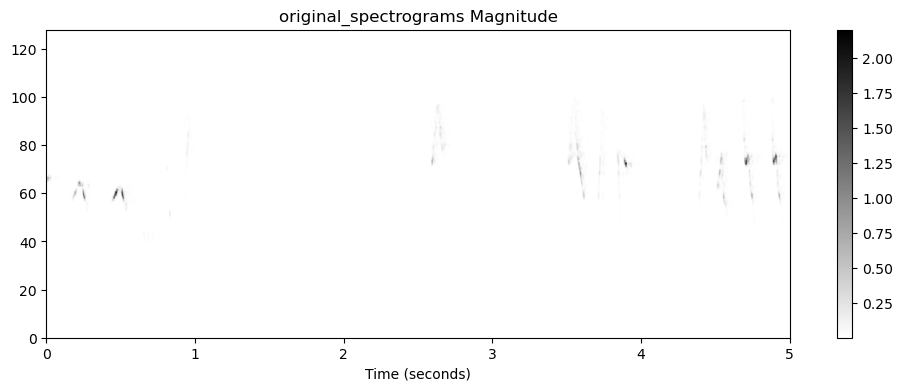

Processing spectrograms_after_median_blurring with shape torch.Size([1, 128, 1126])


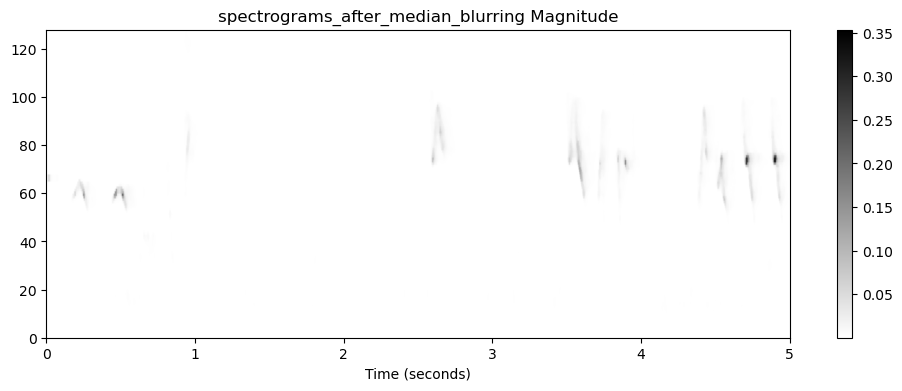

Processing spectrograms_after_median_filtering with shape torch.Size([1, 128, 1126])


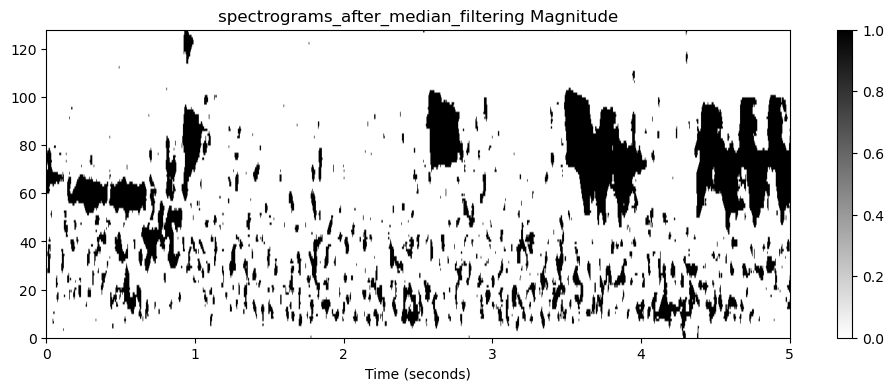

Processing spectrograms_after_spot_removal with shape torch.Size([1, 128, 1126])


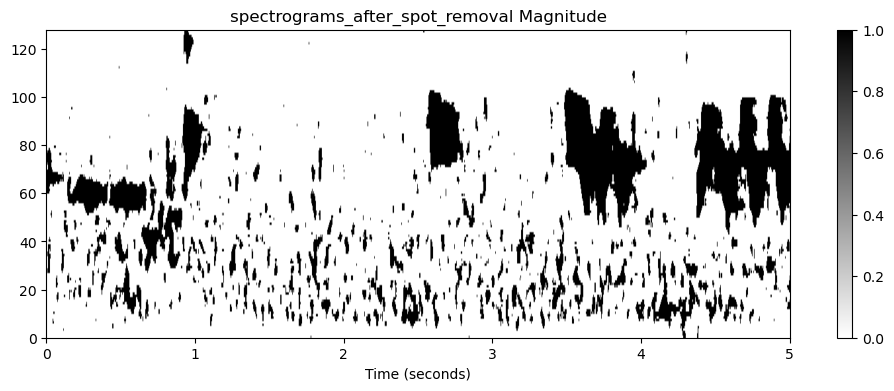

Processing spectrograms_after_morph_closing with shape torch.Size([1, 128, 1126])


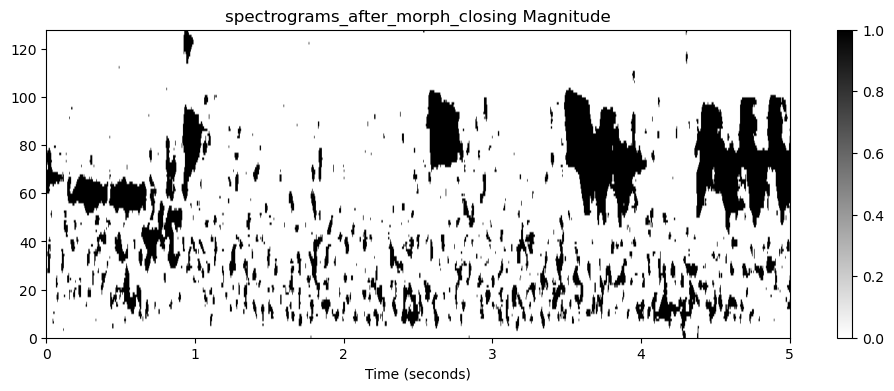

In [8]:
if DEBUG:
    sample, target = train_dataset[75]
    processed_sample, intermediates = sample

    print(processed_sample.shape)
    num_positive_labels = target.sum().item()
    print(f"Number of positive labels: {num_positive_labels}")
    visualize_intermediates(intermediates)

**Calcular la longitud máxima de las formas de onda**

Se determina la longitud máxima entre todas las formas de onda para poder rellenar (padding) o truncar los audios posteriormente, garantizando que todos tengan la misma longitud.

La función `collate_fn` se utiliza para procesar y combinar un lote (batch) de muestras en el dataloader. Asegura que todas las formas de onda tengan la misma longitud (rellenando con ceros si es necesario) y devuelve las formas de onda junto con sus objetivos (etiquetas). Para esto, necesita la longitud máxima calculada anteriormente.

In [9]:
# Calculate the global max length of waveforms in the dataset
# global_max_len = max(
#     max(dataset[i][0][0].shape[2] for i in range(len(dataset)))
#     for dataset in [train_dataset, valid_dataset]
# )
# print(global_max_len)
# # 1126

In [10]:
global_max_len = 1126

In [11]:
def collate_fn(batch):
    # Test set scenario (Does not have targets, the filename is return to have the same output shape)
    if isinstance(batch[0][1], str):
        waveforms, filenames = zip(*batch)
        # Directly pad and return, no need to stack targets
        waveforms = [torch.cat([wf[0], torch.zeros(wf[0].shape[0], wf[0].shape[1], global_max_len - wf[0].shape[2])], dim=2) for wf in waveforms]
        waveforms = torch.stack(waveforms)
        return waveforms, filenames

    # Training or validation batch
    waveforms, targets = zip(*batch)
    waveforms = [torch.cat([wf[0], torch.zeros((1, wf[0].shape[1], global_max_len - wf[0].shape[2]))], dim=2) for wf in waveforms]
    waveforms = torch.stack(waveforms)
    targets = torch.stack(targets)
    return waveforms, targets

BATCH_SIZE=64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

## Definición del modelo

- Se define una arquitectura basada en el modelo ResNet50 preentrenado.
- Se adapta la primera capa convolucional para aceptar imágenes de un solo canal (grises).
- Se elimina la última capa completamente conectada del ResNet y se agrega una clasificación personalizada para adaptar la arquitectura al problema multietiqueta.

Se utiliza una mezcla de *transfer-learning* y *fine-tuning*.

**Transferencia de aprendizaje**:

El modelo se carga y se adaptan algunas capas. Se congelan los pesos de las capas del modelo preentrenado para que no se actualicen durante el entrenamiento inicial, por lo que sólo las capas personalizadas, como la capa de clasificación, se entrenarán. Es decir, se adapta a una tarea diferente el modelo, manteniendo los pesos originales.

**Fine-tuning**:

Después de algunas épocas de entrenamiento determinadas en el código se desbloquean las capas del modelo preentrenado para que sus pesos también puedan actualizarse durante el entrenamiento

```python
if epoch == X:
    for param in model.features.parameters():
        param.requires_grad = True
```

Este fine-tuning ajusta el modelo a los datos específicos para mejorar el rendimiento, aunque causa cierto *overfitting* al sobreescribir los pesos originales con los datos de entrenamiento.




In [12]:
class ResNetMultilabel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetMultilabel, self).__init__()
        # Load pre-trained resnet model
        self.resnet = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept single-channel (grayscale) images
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Remove the last fully connected layer to adapt for our task
        layers = list(self.resnet.children())[:-1]
        self.features = nn.Sequential(*layers)

        # Custom classifier for our multilabel task
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),  # Update dropout rate to 0.2
            nn.Linear(self.resnet.fc.in_features, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
# Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

# Initialize the model
model = ResNetMultilabel(num_classes=len(class_names)).to(device)

# The pre-trained layers are in the 'features' submodule
for param in model.features.parameters():
    param.requires_grad = False


Using: cuda


c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Entrenamiento

- Se utiliza BCE (Binary Cross Entropy), adecuada para problemas de clasificación multietiqueta junto a un optimizador Adam con las tasas de aprendizaje diferentes para cada fase del entrenamiento.
- Se utiliza un programador de learning rate (ReduceLROnPlateau) que disminuye la tasa de aprendizaje si la función de pérdida no mejora.

El proceso de entrenamiento se ejecuta a través de 20 épocas, y durante cada época se calcula la pérdida en entrenamiento y se ajustan los pesos del modelo, se calcula el F1 en entrenamiento, y se pasa el modelo a modo de evaluación para evaluar en el conjunto de validación, calculando tanto la pérdida como el F1 score.

Si el modelo mejora (en F1) se guarda un checkpoint de los pesos. Está implementada, aunque no se usa actualmente, una lógica de early-stop para evitar el sobreajuste.

Después de cada época se ajusta el learning rate según la evolución de la pérdida en validación.

**Búsqueda de umbral**:
- Se inicializa una lista de posibles `thresholds` de 0.1 a 0.5 en incrementos de 0.05. Estos son los umbrales para decidir si una predicción (probabilidad) del modelo es positiva o negativa.
- Para cada umbral se calcula el F1 score en entrenamiento y validación y se elige el umbral que produce el mejor F1 score en el conjunto de validación.

Esto es importante porque las salidas del modelo son valores continuos entre 0 y 1, que representan la confianza del modelo en que esa etiqueta es positiva, y es necesario decidir un umbral (`threshold`) para convertir estas salidas continuas en etiquetas binarias definitivas.

In [14]:
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
criterion = nn.BCELoss()

best_val_loss = float('inf')
best_f1 = float('-inf')
epochs_no_improve = 0
n_epochs_stop = 4
early_stop = False
thresholds = np.arange(0.1, 0.3, 0.05)

for epoch in range(10):
    model.train()
    running_train_loss, all_train_preds, all_train_labels = 0.0, [], []
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        all_train_preds.extend(outputs.detach().cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = running_train_loss / len(train_loader)
    train_f1_scores = [f1_score(all_train_labels, np.array(all_train_preds) > th, average='samples') for th in thresholds]
    best_threshold_index_train = np.argmax(train_f1_scores)
    best_threshold_train = thresholds[best_threshold_index_train]
    train_best_f1 = train_f1_scores[best_threshold_index_train]

    model.eval()
    running_val_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_val_loss / len(valid_loader)
    validation_f1 = f1_score(all_labels, np.array(all_preds) > best_threshold_train, average='samples')
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Training F1: {train_best_f1:.4f}, Validation Loss: {val_loss:.4f}, Validation F1: {validation_f1:.4f} using threshold {best_threshold_train:.2f}")
    
    if validation_f1 > best_f1:
        best_f1 = validation_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        early_stop = True
        break

    scheduler.step()

if early_stop:
    model.load_state_dict(torch.load('best_model.pth'))

print('Finished Training')

Epoch 1, Train Loss: 0.1445, Training F1: 0.1087, Validation Loss: 0.0882, Validation F1: 0.0735 using threshold 0.10
Epoch 2, Train Loss: 0.1005, Training F1: 0.2093, Validation Loss: 0.0793, Validation F1: 0.2077 using threshold 0.10
Epoch 3, Train Loss: 0.0895, Training F1: 0.3249, Validation Loss: 0.0733, Validation F1: 0.2876 using threshold 0.10
Epoch 4, Train Loss: 0.0810, Training F1: 0.3890, Validation Loss: 0.0688, Validation F1: 0.3048 using threshold 0.10
Epoch 5, Train Loss: 0.0751, Training F1: 0.4288, Validation Loss: 0.0664, Validation F1: 0.3390 using threshold 0.10
Epoch 6, Train Loss: 0.0708, Training F1: 0.4566, Validation Loss: 0.0646, Validation F1: 0.3352 using threshold 0.10
Epoch 7, Train Loss: 0.0677, Training F1: 0.4827, Validation Loss: 0.0634, Validation F1: 0.3369 using threshold 0.15
Epoch 8, Train Loss: 0.0659, Training F1: 0.4989, Validation Loss: 0.0624, Validation F1: 0.3531 using threshold 0.15
Epoch 9, Train Loss: 0.0645, Training F1: 0.5127, Valida

## Evaluación y Predicción en el conjunto de Test

1. **Evaluación de las predicciones**:
Se pone el modelo en modo `eval()` y se itera sobre el conjunto de validación para obtener las predicciones y se calcula el F1 usando el mejor umbral.

2. **Preparación del conjunto de Test**:
Se crea la clase `BirdSongTestDataset` que lee de `test.csv`, y se crea un DataLoader para el conjunto de Test.

3. **Predicciones en el conjunto de Test**:
Se itera sobre el conjunto de test y se obtienen las predicciones del modelo para cada archivo de audio. Se binarizan usando el mejor umbral y se almacenan en un diccionario con el nombre del archivo como clave.
Las predicciones se convierten en un DataFrame de Pandas y se preparan los datos en el formato esperado, y por último se guarda el DataFrame en un archivo CSV.

In [19]:
print(f"Best threshold: {best_threshold_train}")

Best threshold: 0.15000000000000002


In [21]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold_train).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1_macro = f1_score(all_labels, all_preds, average='samples')
print(f"F1 Score (Samples): {f1_macro}")

F1 Score (Samples): 0.34620056776919517


In [23]:
test_csv = pd.read_csv(f'{base_path}data/test.csv')

test_dataset = BirdSongDataset(test_csv, f'{base_path}data/test/', is_test=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [18]:
if DEBUG:
  sample, _ = test_dataset[99]
  processed_sample, intermediates = sample

  print(processed_sample.shape)
  visualize_intermediates(intermediates)

ValueError: not enough values to unpack (expected 2, got 1)

In [24]:
# Make predictions on test set
model.eval()
predictions = {}
with torch.no_grad():
    for inputs, filenames in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs > best_threshold_train).float().cpu().numpy().astype(int)
        for fname, pred in zip(filenames, preds):
            predictions[fname] = pred

# Convert predictions to submission format
submission_df = pd.DataFrame.from_dict(predictions, orient='index', columns=class_names)
submission_df.reset_index(inplace=True)
submission_df.rename(columns={'index': 'filename'}, inplace=True)
submission_df.to_csv('submission.csv', index=False)

IndexError: tuple index out of range